In [31]:
from src.data_preprocessor import DataProcessor
from data_configs.configs import *
from models.neural_networks import *
from src.cross_validation import CrossValidation
import numpy as np

config = albalone_config
data_processor = DataProcessor(config=config)
cross_validator = CrossValidation(config=config)

In [32]:
raw_data = data_processor.load_data()
data_1 = data_processor.impute_missing_values(raw_data)
data_2 = data_processor.encode_nominal_features(data_1)
data_3 = data_processor.encode_ordinal_features(data_2)
data_4 = data_processor.standardize_data(data_3,data_3,features=['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight'])

c:\Users\Srikanta\Documents\Intro to Machine Learning\programming_assignment_1\src\data_preprocessor.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)
c:\Users\Srikanta\Documents\Intro to Machine Learning\programming_assignment_1\src\data_preprocessor.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work becaus

In [33]:
data_4 = data_4[['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight','Viscera weight', 'Shell weight','Sex_F', 'Sex_I', 'Sex_M','Rings']]

In [34]:
data_4

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M,Rings
0,-0.574489,-0.432097,-1.064297,-0.641821,-0.607613,-0.726125,-0.638140,0,0,1,15
1,-1.448812,-1.439757,-1.183837,-1.230130,-1.170770,-1.205077,-1.212842,0,0,1,7
2,0.050027,0.122116,-0.107978,-0.309432,-0.463444,-0.356647,-0.207114,1,0,0,9
3,-0.699393,-0.432097,-0.347058,-0.637743,-0.648160,-0.607527,-0.602222,0,0,1,10
4,-1.615350,-1.540523,-1.422916,-1.271933,-1.215822,-1.287183,-1.320599,0,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.341468,0.424414,0.609261,0.118799,0.047902,0.532836,0.073053,1,0,0,11
4173,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666,0,0,1,10
4174,0.632909,0.676328,1.565580,0.708127,0.748470,0.975296,0.496895,0,0,1,9
4175,0.841081,0.777094,0.250642,0.541933,0.773248,0.733540,0.410690,1,0,0,10


In [35]:
data_train, data_val = cross_validator.random_partition(data_4, random_state=42)

In [36]:
data = data_train.to_numpy()
X_train = data[:,:-1]
y_train = data[:,-1:]

In [37]:
data_test = data_val.to_numpy()
X_val = data_test[:,:-1]
y_val = data_test[:,-1:]

In [ ]:
autoE = AutoEncoder(config,n_input=X_train.shape[1],n_encoder=4)

autoE.train(X_train, max_epochs=30000, lr=0.0001)

In [38]:
ffn = FeedForwardNetwork(config,n_input=X_train.shape[1],n_hidden_1=24,n_hidden_2=24,n_output=1)

MSEs, val_metrics, final_mse = ffn.train(X_train,y_train,X_val,y_val,3000,0.000001)

Epoch 0/3000, Train MSE: 108.51596323226543, Val MSE: 107.97656223610541


Epoch 100/3000, Train MSE: 59.35599043487487, Val MSE: 59.13557124350659
Epoch 200/3000, Train MSE: 12.773369073024009, Val MSE: 12.967571680816858
Epoch 300/3000, Train MSE: 6.4330750433174115, Val MSE: 6.613397211550754
Epoch 400/3000, Train MSE: 6.208657462594572, Val MSE: 6.383329624149149
Epoch 500/3000, Train MSE: 5.985696171174245, Val MSE: 6.1604807527149585
Epoch 600/3000, Train MSE: 5.752663632318692, Val MSE: 5.935178769904722
Epoch 700/3000, Train MSE: 5.515657840754807, Val MSE: 5.717021530289249
Epoch 800/3000, Train MSE: 5.300415091959838, Val MSE: 5.533031174898138
Epoch 900/3000, Train MSE: 5.136729770066577, Val MSE: 5.407740306800641
Epoch 1000/3000, Train MSE: 5.030704200938752, Val MSE: 5.337097392968061
Epoch 1100/3000, Train MSE: 4.966879656333608, Val MSE: 5.298442469646089
Epoch 1200/3000, Train MSE: 4.928274141298752, Val MSE: 5.273920890657002
Epoch 1300/3000, Train MSE: 4.9039131049863585, Val MSE: 5.255253270450942
Epoch 1400/3000, Train MSE: 4.887586299319

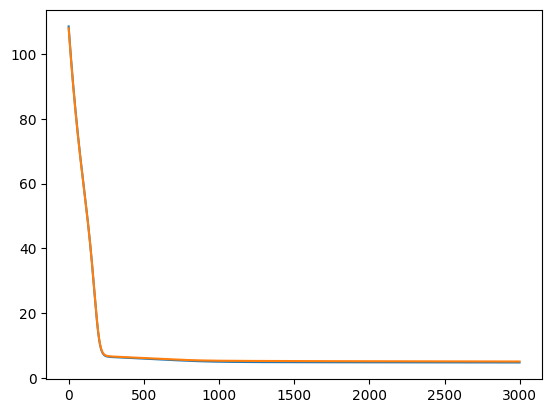

In [39]:
import matplotlib.pyplot as plt

plt.plot(MSEs)
plt.plot(val_metrics)

In [40]:
linear = LinearNetwork(config)

losses = linear.linear_regression(X_train,y_train,X_val,y_val)

Epoch 0/1000, Training MSE: 108.90877403560643, Validation MSE: 102.44410728466258
Epoch 100/1000, Training MSE: 6.516938879446768, Validation MSE: 6.577528977266407
Epoch 200/1000, Training MSE: 5.6084509819971755, Validation MSE: 5.69106671979239
Epoch 300/1000, Training MSE: 5.343795670286212, Validation MSE: 5.436539505829112
Epoch 400/1000, Training MSE: 5.187668423914751, Validation MSE: 5.293965851133635
Epoch 500/1000, Training MSE: 5.091152921772452, Validation MSE: 5.21077038458226
Epoch 600/1000, Training MSE: 5.029879300259159, Validation MSE: 5.161146261492091
Epoch 700/1000, Training MSE: 4.990108115135463, Validation MSE: 5.131013516479035
Epoch 800/1000, Training MSE: 4.963697767434541, Validation MSE: 5.112344541195539
Epoch 900/1000, Training MSE: 4.945688780211776, Validation MSE: 5.1004410513083585
